# Technical notebook - Calssification using Neural Network

### Summary of the used methodology



## Import libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
#conda install -c conda-forge imbalanced-learn

## 1. Import Dataset

In [4]:
X_train = pd.read_csv('preprocessing/X_train2.csv', header=None)
y_train = pd.read_csv('preprocessing/y_train2.csv', header=None)
X_test = pd.read_csv('preprocessing/X_test2.csv', header=None)
y_test = pd.read_csv('preprocessing/y_test2.csv', header=None)

FileNotFoundError: [Errno 2] File preprocessing/X_train2.csv does not exist: 'preprocessing/X_train2.csv'

In [517]:
feats = pd.read_csv('preprocessing/features.csv', header=None).iloc[:, 0].tolist()

In [424]:
print('X_train:', X_train.shape,'\nX_test:', X_test.shape)
print('y_train:', y_train.shape,'\ny_test:', y_test.shape)

X_train: (184107, 110) 
X_test: (46027, 110)
y_train: (184107, 1) 
y_test: (46027, 1)


## 2. Manage Imbalance Data By Undersampling

In [426]:
default_train = len(y_train[y_train[0]==1])
print(f'The number of rows in the minority (default) category in train: {default_train:,}.')

default_test = len(y_test[y_test[0]==1])
print(f'The number of rows in the minoriy (default) category in test: {default_test:,}.')

The number of rows in the minority (default) category in train: 32,636.
The number of rows in the minoriy (default) category in test: 8,159.


In [427]:
def under_sampling(X_data, y_data):
    
    default_indices = y_data[y_data[0]==1].index #find the default indices
    non_default_indices = y_data[y_data[0]==0].index #find the non-default indices
    
    #sample indices from non-default:
    sample_indices = random.sample(non_default_indices.tolist(), len(default_indices))
    
    #concatenate indices all defaulted, sample non-defaulted
    under_sample_indices = sample_indices + default_indices.tolist()
    
    #get the dataset by indices
    X_data_under = X_data.loc[under_sample_indices]
    y_data_under = y_data.loc[under_sample_indices]
    
    return X_data_under, y_data_under

In [428]:
X_train_under, y_train_under = under_sampling(X_train, y_train)
print('X_train_under:', X_train_under.shape,'\ny_train_under:', y_train_under.shape)

X_train_under: (65272, 110) 
y_train_under: (65272, 1)


In [429]:
X_test_under, y_test_under = under_sampling(X_test, y_test)
print('X_test_under:', X_test_under.shape,'\ny_test_under:', y_test_under.shape)

X_test_under: (16318, 110) 
y_test_under: (16318, 1)


In [14]:
# pip install --upgrade pip
# pip install tensorflow
# conda install -c anaconda keras

## 3. Baseline - Logistic Regeression

In [430]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

params = {'C': np.logspace(-2, 4, 7),
          'penalty' : ['l1','l2']}

log_grid = GridSearchCV(estimator=LogisticRegression(random_state=123),
                          param_grid=params,
                          scoring='accuracy',
                          cv=5, verbose=2, n_jobs=-1)

log_grid.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   42.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=123, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [431]:
print(f'Best score: {log_grid.best_score_:.3f}')
print('Best parameters:\n\t',log_grid.best_params_)
print(f'Test score: {log_grid.best_estimator_.score(X_test_under, y_test_under):.3f}')

Best score: 0.648
Best parameters:
	 {'C': 1000.0, 'penalty': 'l2'}
Test score: 0.641


In [537]:
coefs = pd.DataFrame(zip(feats, log_grid.best_estimator_.coef_[0]), columns=['Feature', 'Coef'])
coefs.sort_values(by='Coef')[:10]

,Feature,Coef
9,open_acc,-0.440430
38,total_il_high_credit_limit,-0.184198
107,annual_inc_log,-0.159314
13,tot_cur_bal,-0.154170
0,loan_amnt,-0.136911
109,total_bc_limit_log,-0.135718
19,mo_sin_old_rev_tl_op,-0.110790
31,num_rev_accts,-0.104849
7,fico_range_low,-0.103937
23,mths_since_recent_bc,-0.078274


In [538]:
coefs.sort_values(by='Coef')[-10:]

,Feature,Coef
41,percent_bc_gt_75_cat,0.086876
6,earliest_cr_line,0.106392
36,tot_hi_cred_lim,0.119769
5,dti,0.132166
14,acc_open_past_24mths,0.153702
37,total_bal_ex_mort,0.176381
2,installment,0.291328
3,grade,0.291849
1,term,0.338977
33,num_sats,0.450588


#### Evaluate on imbalance dataset

In [ ]:
from sklearn import metrics

def get_metrics(y_true, y_pred, y_pred_prob):
    auc = metrics.roc_auc_score(y_true, y_pred_prob)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    return accuracy, recall, precision, f1, auc

In [433]:
y_test_pred_lr = log_grid.best_estimator_.predict(X_test)
y_test_pred_prob_lr = log_grid.best_estimator_.decision_function(X_test)
acc, recall, precision, f1, auc = get_metrics(y_test, y_test_pred_lr, y_test_pred_prob_lr)

print(f'Accuracy:\tF1_score:\tPrecision:\tRecall: \tAUC:')
print(f'{acc:.1%}\t\t{f1:.1%}\t\t{precision:.1%}\t\t{recall:.1%}\t\t{auc:.1%}')

display(pd.crosstab(y_test.values.flatten(), y_test_pred_lr, rownames=['Actual'], 
        colnames=['Predicted'], margins = True, normalize=True).applymap(lambda x: f'{x:.2f}'))

Accuracy:	F1_score:	Precision:	Recall: 	AUC:
64.4%		39.2%		28.1%		64.8%		70.4%


Predicted,0,1,All
Actual,,,
0,0.53,0.29,0.82
1,0.06,0.11,0.18
All,0.59,0.41,1.00


## 4. Build the MLP Model

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
tf.__version__

Using TensorFlow backend.


'1.14.0'

In [261]:
#metrics:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [3]:
model = Sequential()

model.add(Dense(units=96, activation='relu', input_dim=X_train_under.shape[1]))
model.add(Dropout(0.5)) #reduces overfitting
model.add(Dense(units=48, activation='relu'))
model.add(Dropout(0.3)) #reduces overfitting
model.add(Dense(units=24, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',
               metrics=['accuracy', recall_m, f1_m, precision_m])

NameError: name 'X_train_under' is not defined

In [474]:
model.fit(X_train_under, y_train_under, epochs=1000, verbose=2, validation_split=0.2,
          callbacks=[EarlyStopping(monitor='val_f1_m', mode='max', patience=20, restore_best_weights=True)])


Train on 52217 samples, validate on 13055 samples
Epoch 1/1000
 - 5s - loss: 0.6584 - accuracy: 0.6228 - recall_m: 0.1406 - f1_m: 0.2013 - precision_m: 0.4753 - val_loss: 0.8306 - val_accuracy: 0.1517 - val_recall_m: 0.1517 - val_f1_m: 0.2578 - val_precision_m: 0.9951
Epoch 2/1000
 - 4s - loss: 0.6219 - accuracy: 0.6487 - recall_m: 0.2202 - f1_m: 0.3052 - precision_m: 0.5797 - val_loss: 0.8572 - val_accuracy: 0.2555 - val_recall_m: 0.2555 - val_f1_m: 0.4011 - val_precision_m: 1.0000
Epoch 3/1000
 - 4s - loss: 0.6160 - accuracy: 0.6553 - recall_m: 0.2619 - f1_m: 0.3482 - precision_m: 0.5851 - val_loss: 0.8603 - val_accuracy: 0.2890 - val_recall_m: 0.2890 - val_f1_m: 0.4425 - val_precision_m: 1.0000
Epoch 4/1000
 - 4s - loss: 0.6123 - accuracy: 0.6593 - recall_m: 0.2747 - f1_m: 0.3627 - precision_m: 0.6017 - val_loss: 0.8319 - val_accuracy: 0.3854 - val_recall_m: 0.3854 - val_f1_m: 0.5512 - val_precision_m: 1.0000
Epoch 5/1000
 - 4s - loss: 0.6121 - accuracy: 0.6602 - recall_m: 0.2919 - 

 - 4s - loss: 0.5968 - accuracy: 0.6786 - recall_m: 0.3817 - f1_m: 0.4585 - precision_m: 0.6168 - val_loss: 0.8602 - val_accuracy: 0.3529 - val_recall_m: 0.3529 - val_f1_m: 0.5165 - val_precision_m: 1.0000
Epoch 39/1000
 - 4s - loss: 0.5953 - accuracy: 0.6799 - recall_m: 0.3895 - f1_m: 0.4624 - precision_m: 0.6127 - val_loss: 0.8562 - val_accuracy: 0.3751 - val_recall_m: 0.3751 - val_f1_m: 0.5408 - val_precision_m: 1.0000
Epoch 40/1000
 - 6s - loss: 0.5943 - accuracy: 0.6803 - recall_m: 0.3938 - f1_m: 0.4664 - precision_m: 0.6156 - val_loss: 0.9110 - val_accuracy: 0.3398 - val_recall_m: 0.3398 - val_f1_m: 0.5020 - val_precision_m: 1.0000
Epoch 41/1000
 - 4s - loss: 0.5943 - accuracy: 0.6789 - recall_m: 0.3929 - f1_m: 0.4648 - precision_m: 0.6111 - val_loss: 0.8569 - val_accuracy: 0.3878 - val_recall_m: 0.3878 - val_f1_m: 0.5541 - val_precision_m: 1.0000
Epoch 42/1000
 - 4s - loss: 0.5944 - accuracy: 0.6785 - recall_m: 0.3889 - f1_m: 0.4628 - precision_m: 0.6090 - val_loss: 0.8599 - val

#### Model performance on balanced test set

In [475]:
# evaluate the model
y_test_under_pred = model.predict_classes(X_test_under).flatten()
y_test_under_pred_prob = model.predict_proba(X_test_under)
acc, recall, precision, f1, auc = get_metrics(y_test_under, y_test_under_pred, y_test_under_pred_prob)

print(f'Accuracy:\tF1_score:\tPrecision:\tRecall: \tAUC:')
print(f'{acc:.1%}\t\t{f1:.1%}\t\t{precision:.1%}\t\t{recall:.1%}\t\t{auc:.1%}')


display(pd.crosstab(y_test_under.values.flatten(), y_test_under_pred, rownames=['Actual'], 
        colnames=['Predicted'], margins = True, normalize=True).applymap(lambda x: f'{x:.2f}'))

Accuracy:	F1_score:	Precision:	Recall: 	AUC:
62.4%		53.3%		70.3%		42.9%		70.3%


Predicted,0,1,All
Actual,,,
0,0.41,0.09,0.50
1,0.29,0.21,0.50
All,0.69,0.31,1.00


#### Model performance on the original (imbalanced) test set

In [476]:
# evaluate the model
from sklearn import metrics

y_test_pred = model.predict_classes(X_test).flatten()
y_test_pred_prob = model.predict_proba(X_test)
acc, recall, precision, f1, auc = get_metrics(y_test, y_test_pred, y_test_pred_prob)

print(f'Accuracy:\tF1_score:\tPrecision:\tRecall: \tAUC:')
print(f'{acc:.1%}\t\t{f1:.1%}\t\t{precision:.1%}\t\t{recall:.1%}\t\t{auc:.1%}')


display(pd.crosstab(y_test.values.flatten(), y_test_pred, rownames=['Actual'], 
        colnames=['Predicted'], margins = True, normalize=True).applymap(lambda x: f'{x:.2f}'))

Accuracy:	F1_score:	Precision:	Recall: 	AUC:
74.8%		37.6%		33.5%		42.9%		70.4%


Predicted,0,1,All
Actual,,,
0,0.67,0.15,0.82
1,0.10,0.08,0.18
All,0.77,0.23,1.00


## 5. Compare the models with ROC curves

In [487]:
def plot_roc(y_test, y_pred, name):
    fpr, tpr, tresh = metrics.roc_curve(y_test, y_pred)
    auc_score = round(metrics.roc_auc_score(y_test, y_pred),3)
    plt.plot(fpr, tpr, label = f'{name}   (auc = {auc_score})')

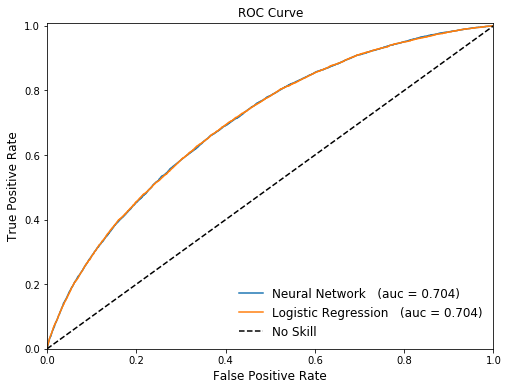

In [536]:
fig = plt.figure(figsize=(8,6))

plot_roc(y_test, model.predict_proba(X_test), 'Neural Network')
plot_roc(y_test, log_grid.best_estimator_.decision_function(X_test), 'Logistic Regression')

plt.plot([0,1],[0,1],'--', color='black', label = 'No Skill') #diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc = 'lower right', frameon=False, fontsize=12)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.show()

## 6. Compare the models with Precision-Recall curves

In [485]:
def plot_prc(y_test, y_pred, name):
    precision, recall, thresh = metrics.precision_recall_curve(y_test, y_pred)
#     f1 = metrics.f1_score(y_test, y_pred)
    plt.plot(recall, precision, label = f'{name}')

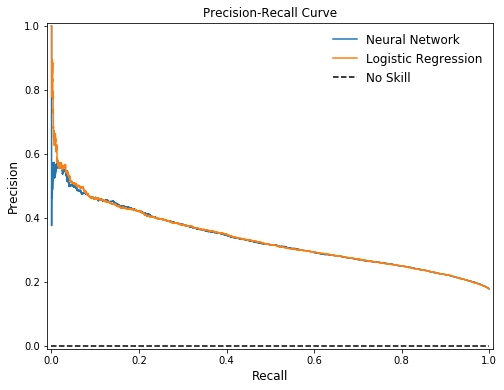

In [535]:
fig = plt.figure(figsize=(8,6))

plot_prc(y_test, model.predict_proba(X_test), 'Neural Network')
plot_prc(y_test, log_grid.best_estimator_.decision_function(X_test), 'Logistic Regression')

plt.plot([0, 1], [0, 0], linestyle='--',  color='black', label = 'No Skill') #horizontal line below

# plt.plot([0,1],[0,1],'--', color='black') #diagonal line
plt.title('Precision-Recall Curve')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend(loc = 'upper right', frameon=False, fontsize=12)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.show()